# <center> Dam Break Test Case </center>
## <center> SPH Project </center>

<center> Based on the work of Rémi Carmigniani et Damien Violeau </center>
<center> Density diffusion added by Ludovic Druette and Théo Contentin </center>

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sys import exit
import os.path
from os import path
import csv
import time
import matplotlib
import matplotlib.pyplot as plt
from src.spyh import *
from src.sphvar import *
from src.plotParticles import *
from src.state import *
from src.contrib import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
current_directory = os.getcwd()
results_directory = os.path.join(current_directory, r'Results')
try:
    os.mkdir(results_directory)
except FileExistsError:
    pass

case_directory = os.path.join(results_directory, r'DensityDiffusion_'+time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(case_directory)
data_directory = os.path.join(case_directory,r'Data')
figures_directory = os.path.join(case_directory,r'Figures')
os.mkdir(data_directory)
os.mkdir(figures_directory)

In [17]:
import scipy.io as sio
validation = sio.loadmat('.dam_break/validation/Data_Table_Martin_1952_n2_2.mat')

# For pressure Zhou et al. 1999
pressure_val = np.genfromtxt('.dam_break/validation/zhouetal_1999_p2.csv', delimiter=',')[1:]

In [98]:
#FLUID PARAMETERS
rhoF = 1000
c0 = 40
gamma = 7
B = rhoF*c0**2/gamma
grav = np.array([0,-9.81]) 
#ARTIFICIAL VISCOSITY (voir plus loin)
alpha = 0.0
esp=10**(-6) #and it is multiplied by dr**2 in the code
#DENSITY DIFFUSION
densityDiffusion = True
delta = 0.05
#DENSITY & SHEPARD THRESHOLDS : 
shepardMin = 10**(-6)
rhoMin = 0.5*rhoF
rhoMax = 1.5*rhoF
#GEOMETRY
Lx = 2
Ly = 2
lx = 0.5
ly=1

In [99]:
#PARTICLES & SPACES PARAMETERS : 
dr = ly/30

In [100]:
h = smthfc*dr
m=dr*dr*rhoF
lspace = 2*h
#COMPUTATION DOMAIN : 
xOrigin = -nBound*dr
yOrigin = -nBound*dr
xSize = Lx+2*nBound*dr
ySize = Ly+2*nBound*dr
xMax = xOrigin+xSize
yMax = yOrigin+ySize
#INIT SPACES & PART:
posSpace,neibSpace,partSpace,listNeibSpace = \
init_spaces(xOrigin,yOrigin,xSize,ySize,lspace,dr)
part = init_particles()
part = addBox(part,[lx,ly],FLUID,dr,rhoF)
part = addBox(part,[-nBound*dr,-nBound*dr,Lx+2*nBound*dr,nBound*dr],BOUND,dr,rhoF)
part = addBox(part,[-nBound*dr,0,nBound*dr,Ly],BOUND,dr,rhoF)
part = addBox(part,[Lx,0,nBound*dr,Ly],BOUND,dr,rhoF)
part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)

In [101]:
#time, iteration count and im_count
t = 0
it=0
im_count=0
#
simvaluesTHX = np.empty((0,5),float)
Hmax = np.max(part[part[:,INFO]==FLUID,POS[1]])+dr*0.5
Xmax = np.max(part[part[:,INFO]==FLUID,POS[0]])+dr*0.5
# Presure interpolation on the boundary at x = 2, z = 0.2 code from interpolateBoundary
# keep only the fluid particles
listnb = (part[:,INFO]==FLUID)
rPos = np.array([2,0.2]) - part[:,POS][listnb]
rNorm = (rPos[:, 0] * rPos[:, 0] + rPos[:, 1] * rPos[:, 1]) ** 0.5
q = rNorm / h
w_ij = wend(q, aW, h)
#
rho_j = part[:,RHO][listnb]
vel_j = part[:,VEL][listnb][:]
P_j = pressure(rho_j, B, rhoF, gamma)
rho_j[rho_j < rhoF] = rhoF
vol_j = m / rho_j
rho_j = part[:,RHO][listnb]
PressInt = pressureInterpolationContrib(rho_j, P_j, vol_j, rPos, w_ij, grav)
PressInt[PressInt < 0] = 0
shepard = shepardContrib(vol_j, w_ij)
shepard = max(np.sum(shepard, 0), shepardMin)
# COMPLETE HERE
# VTildeInt_x = -vel_j[:, 0] * vol_j * w_ij
# VTildeInt_y = -vel_j[:, 1] * vol_j * w_ij
# partVel[i, 0] = np.sum(VTildeInt_x, 0) / shepard
# partVel[i, 1] = np.sum(VTildeInt_y, 0) / shepard
# END
PX2Z02 = np.sum(PressInt, 0) / shepard
#Total mecanic energy of the system
energyTotal = np.sum(m/2 * np.sum(part[:,VEL][listnb] * part[:,VEL][listnb],axis =1) - (m*grav*part[:,POS][listnb])[:,1])
simvaluesTHX= np.append(simvaluesTHX,[[t,Hmax,Xmax,PX2Z02,energyTotal]],axis=0)
# Here we specify the output frequencies
dt_figure = 2./100.*(ly/np.linalg.norm(grav))**.5
t_print = 0
#final time :
t_end = 10

In [25]:
# Adimensionalize pressure validation results
pressure_val[:,0] = pressure_val[:,0]*np.sqrt(9.81/0.60) # *sqrt(g/H)
pressure_val[:,1] = pressure_val[:,1]/(1000*9.81*0.60) # /(rho*g*g)

<IPython.core.display.Javascript object>


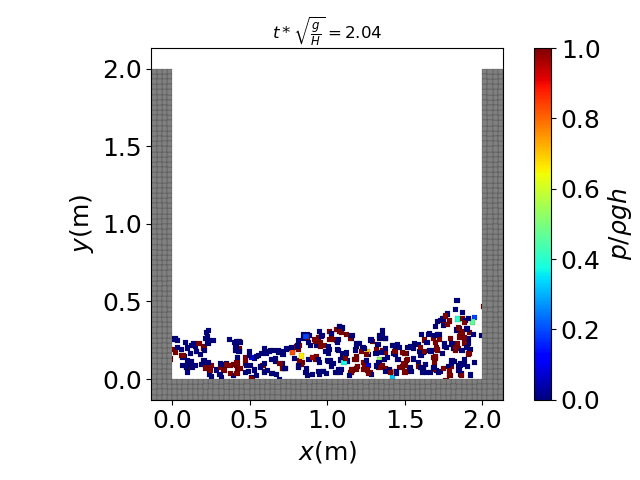

<IPython.core.display.Javascript object>


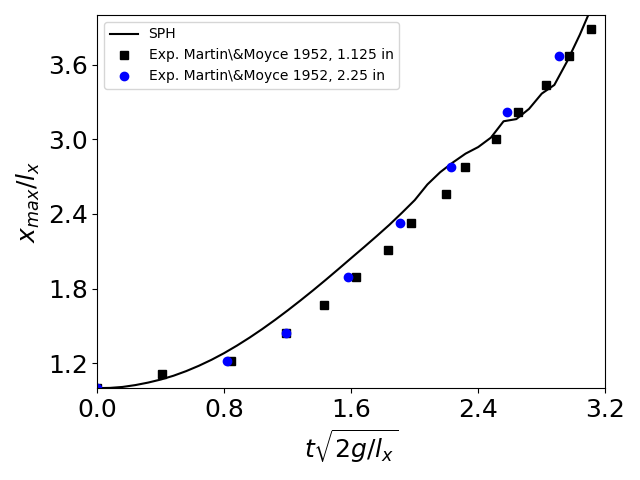

<IPython.core.display.Javascript object>


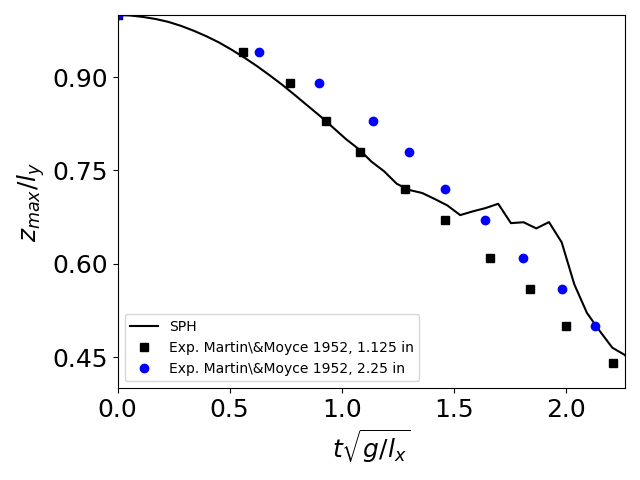

<IPython.core.display.Javascript object>


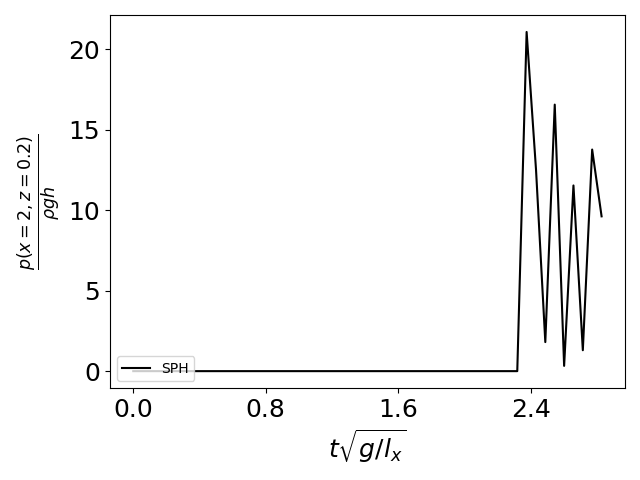

1 particles are deleted because outside computational domain


ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

1 particles are deleted because outside computational domain
1 particles are deleted because outside computational domain


ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py


ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
2 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
4 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
2 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
2 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sph

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 p

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
1 particles are deleted because outside computational domain
ATT

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
ATTENTION : too many neibs in a space... increase maxPartInSpace

SystemError: CPUDispatcher(<function computeForcesART at 0x7f7ed3730550>) returned a result with an exception set

KeyboardInterrupt: 

In [8]:
%matplotlib notebook
while t<t_end:
    #STEP1 : Calcul de la CFL
    dt = CFLConditions(part[:,VEL],h,c0,grav)
    #STEP2 : Interpolation des conditions au bord
    part[:,RHO],part[:,VEL] =interpolateBoundary((part[:,INFO]==BOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,shepardMin)
    #STEP3 : Calcul des forces et des termes de densité
    part[:,FORCES],part[:,DRHODT] = computeForcesART((part[:,INFO]==FLUID),\
                                                 part[:,SPID],\
                                                 part[:,POS],\
                                                 part[:,VEL],\
                                                 part[:,RHO],\
                                                 listNeibSpace,\
                                                 aW,h,m,B,rhoF,gamma,grav,alpha,esp,dr,\
                                                 c0,delta, densityDiffusion=densityDiffusion)
    #STEP4 : Integration en temps
    part[:,POS],part[:,VEL],part[:,RHO] = integrationStep((part[:,INFO]==FLUID),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                     dt)
    #STEP5 : Corriger densité trop basse
    part[:,RHO] = checkDensity(part[:,RHO],rhoMin,rhoMax)
    #STEP6 : Mise à jour des voisins (pas forcément à tous les pas de temps)
    part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
    listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
    t +=dt
    it +=1
    if t>=t_print:
        # Pressure
        fig = plt.figure(1)
        plt.clf()
        plt.title(r'$t*\sqrt{\frac{g}{H}} = %2.2f$'%(t*(np.linalg.norm(grav)/ly)**.5))
        press = pressure(part[:,RHO], B, rhoF, gamma)
        pressMagn = press/(rhoF*ly*np.linalg.norm(grav))
        domain = [xOrigin,xMax,yOrigin,yMax,0,1]
        plotPropertiesWithBound(part,pressMagn,r'$p/\rho g h$',domain,dr,1)
        figname = os.path.join(figures_directory,r'press_%06d.png'%im_count)
        im_count = im_count+1
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)
        #extract front
        Hmax = np.max(part[part[:,INFO]==FLUID,POS[1]])+dr*0.5
        Xmax = np.max(part[part[:,INFO]==FLUID,POS[0]])+dr*0.5
        listnb = (part[:,INFO]==FLUID)
        rPos = np.array([2,0.2]) - part[:,POS][listnb]
        rNorm = (rPos[:, 0] * rPos[:, 0] + rPos[:, 1] * rPos[:, 1]) ** 0.5
        q = rNorm / h
        w_ij = wend(q, aW, h)
        #
        rho_j = part[:,RHO][listnb]
        vel_j = part[:,VEL][listnb][:]
        P_j = pressure(rho_j, B, rhoF, gamma)
        rho_j[rho_j < rhoF] = rhoF
        vol_j = m / rho_j
        rho_j = part[:,RHO][listnb]
        PressInt = pressureInterpolationContrib(rho_j, P_j, vol_j, rPos, w_ij, grav)
        PressInt[PressInt < 0] = 0
        shepard = shepardContrib(vol_j, w_ij)
        shepard = max(np.sum(shepard, 0), shepardMin)
        # COMPLETE HERE
        # VTildeInt_x = -vel_j[:, 0] * vol_j * w_ij
        # VTildeInt_y = -vel_j[:, 1] * vol_j * w_ij
        # partVel[i, 0] = np.sum(VTildeInt_x, 0) / shepard
        # partVel[i, 1] = np.sum(VTildeInt_y, 0) / shepard
        # END
        PX2Z02 = np.sum(PressInt, 0) / shepard
        energyTotal = energyTotal = np.sum(m/2 * np.sum(part[:,VEL][listnb] * part[:,VEL][listnb],axis =1) - (m*grav*part[:,POS][listnb])[:,1])
        simvaluesTHX= np.append(simvaluesTHX,[[t,Hmax,Xmax,PX2Z02,energyTotal]],axis=0)
        #plot figure of t and Xmax
        fig = plt.figure(3)
        plt.clf()
        plt.plot(simvaluesTHX[:,0]*(2*np.linalg.norm(grav)/lx)**.5,simvaluesTHX[:,2]/lx,'-k',label=r'SPH')
        plt.plot(validation["damb2ZT"][:,1],validation["damb2ZT"][:,0],'ks', label=r'Exp. Martin\&Moyce 1952, 1.125 in')       
        plt.plot(validation["damb1ZT"][:,1],validation["damb1ZT"][:,0],'bo',label = r'Exp. Martin\&Moyce 1952, 2.25 in')
        plt.xlabel('$t\sqrt{2g/l_x}$',fontsize=18)
        plt.ylabel('$x_{max}/l_x$',fontsize=18)
        plt.xlim(0,3.2)
        plt.ylim(1,4) 
        ax = plt.gca()
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show(block=False)
        plt.draw()
        figname = os.path.join(case_directory,r'graph_xt.pdf')
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)
        #plot figure of t and Hmax
        fig = plt.figure(4)
        plt.clf()
        plt.plot(simvaluesTHX[:,0]*(np.linalg.norm(grav)/lx)**.5,simvaluesTHX[:,1]/ly,'-k',label=r'SPH')
        plt.plot(validation["damb2HT"][:,1],validation["damb2HT"][:,0],'ks',label=r'Exp. Martin\&Moyce 1952, 1.125 in')           
        plt.plot(validation["damb1HT"][:,1],validation["damb1HT"][:,0],'bo',label =r'Exp. Martin\&Moyce 1952, 2.25 in')
        plt.xlabel('$t\sqrt{g/l_x}$',fontsize=18)
        plt.ylabel('$z_{max}/l_y$',fontsize=18)
        plt.xlim(0,3.2/2**.5)
        plt.ylim(0.4,1) 
        ax = plt.gca()
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        plt.legend(loc='lower left')
        plt.tight_layout()
        plt.show(block=False)
        plt.draw()
        figname = os.path.join(case_directory,r'graph_ht.pdf')
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)
        #plot figure of t and p at x = 2, z = 0.2
        fig = plt.figure(5)
        plt.clf()
        plt.plot(simvaluesTHX[:,0]*(np.linalg.norm(grav)/lx)**.5,simvaluesTHX[:,3]/(rhoF*ly*np.linalg.norm(grav)),'-k',label=r'SPH')
        plt.xlabel(r'$t\sqrt{g/l_x}$',fontsize=18)
        plt.ylabel(r'$\frac{p(x=2,z=0.2)}{\rho gh}$',fontsize=18)
        ax = plt.gca()
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        plt.legend(loc='lower left')
        plt.tight_layout()
        plt.show(block=False)
        plt.draw()
        figname = os.path.join(case_directory,r'graph_pt.pdf')
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)
        #plot figure of t and total mecanical energy
        fig = plt.figure(6)
        plt.clf()
        plt.plot(simvaluesTHX[:,0]*(np.linalg.norm(grav)/lx)**.5,simvaluesTHX[:,4],'-k',label=r'SPH')
        plt.xlabel(r'$t\sqrt{g/l_x}$',fontsize=18)
        plt.ylabel(r'Total energy',fontsize=18)
        ax = plt.gca()
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        plt.legend(loc='lower left')
        plt.tight_layout()
        plt.show(block=False)
        plt.draw()
        figname = os.path.join(case_directory,r'graph_et.pdf')
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)
        t_print = t_print+dt_figure

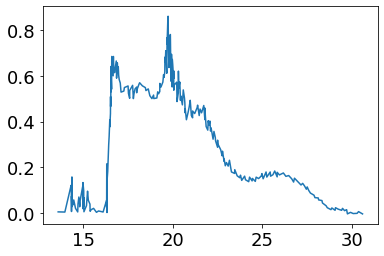

In [26]:
dataname = os.path.join(results_directory,r'Data_deltanu'+str(alpha)+'_'+str(delta)+'.npy')
with open(dataname,'ab') as f:
    np.save(f,simvaluesTHX)


array([[0.00000000e+00, 1.00000000e+00, 5.00000000e-01, 0.00000000e+00,
        2.45250000e+03],
       [1.66666667e-04, 9.99999737e-01, 5.00000001e-01, 0.00000000e+00,
        2.45249934e+03],
       [6.49493736e-03, 9.99795998e-01, 5.00114021e-01, 0.00000000e+00,
        2.45239973e+03],
       ...,
       [8.94616210e+00, 3.03848911e-01, 2.00525420e+00, 8.96771933e+02,
        6.33938177e+02],
       [8.95263932e+00, 3.03365692e-01, 2.00522946e+00, 8.93113825e+02,
        6.33950900e+02],
       [8.95895024e+00, 3.02892392e-01, 2.00520617e+00, 8.89595616e+02,
        6.33962820e+02]])